In [12]:
from binconvfm.models.binconv import BinConvForecaster
from binconvfm.datamodules import SinDataModule
import matplotlib.pyplot as plt
from tqdm import trange
import torch

In [6]:
batch_size = 256
horizon = 50
input_len = 100
output_len = 1
datamodule = SinDataModule(batch_size, horizon, input_len, output_len)

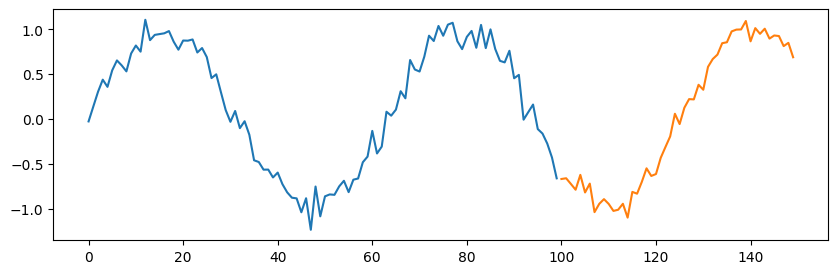

In [7]:
datamodule.setup("predict")
input_seq, target_seq = datamodule.pred_ds[0]
plt.figure(figsize=(10, 3))
plt.plot(range(0, input_len), input_seq)
plt.plot(range(input_len, input_len+horizon), target_seq)
plt.show()

In [8]:
model = BinConvForecaster(num_epochs=5, n_samples=10, context_length=input_len, num_filters_2d=input_len,
                          num_filters_1d=input_len, num_bins=256, min_bin_value=-1.5, max_bin_value=1.5, num_blocks=1,
                          dropout=0.0)
model.fit(datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | BinConv | 36.2 K | train
------------------------------------------
36.2 K    Trainable params
0         Non-trainable params
36.2 K    Total params
0.145     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                         | 0/? [00:00<?, ?it/s]

Training: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                              | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [9]:
model.evaluate(datamodule)

/Users/vitaliypozdnyakov/miniconda3/envs/binconv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                 | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          crps              0.06164903938770294
          mase              1.0890389680862427
          nmae              0.20317061245441437
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'mase': 1.0890389680862427,
 'crps': 0.06164903938770294,
 'nmae': 0.20317061245441437}

In [10]:
pred = model.predict(datamodule, horizon=horizon)
pred[0].shape

/Users/vitaliypozdnyakov/miniconda3/envs/binconv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                              | 0/? [00:00<?, ?it/s]

torch.Size([256, 10, 50, 1])

In [ ]:
idx0 = torch.randint(len(pred), (1,)).item()
idx1 = torch.randint(len(pred[idx0]), (1,)).item()
input_seq, target_seq = list(datamodule.predict_dataloader())[idx0]
input_seq, target_seq = input_seq[idx1, :], target_seq[idx1, :]
input_seq.shape, target_seq.shape

In [ ]:
q = torch.tensor([0.01, 0.5, 0.99])
pred_seq = torch.quantile(pred[idx0][idx1, :, :, -1], q=q, dim=0)

plt.figure(figsize=(10, 3))
plt.plot(range(input_len + horizon), torch.concat([input_seq, target_seq]))
plt.plot(range(input_len, input_len + horizon), pred_seq[1])
plt.fill_between(range(input_len, input_len + horizon), pred_seq[0], pred_seq[2], alpha=0.5, color='tab:orange')
plt.show()